In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df_list=pd.read_csv('/content/drive/MyDrive/bareily_hourly.csv')
full_dataset=pd.DataFrame(df_list)

In [ ]:
full_dataset.head()

,Unnamed: 0,Smart_Meter,Timestamp,Electricity_consumption(kWh),Avg_Voltage(Volt),Avg_Current(Amp),Freq(Hz),Date,Year,Month,Week,Day,Dayofyear,Dayofweek,Weekday,Hour,Minute,Quarter,TIME,Season,Time,Time_Category
0,0,BR02,2019-07-10 00:00:00,0.405,242.099,1.7680,50.0240,2019-07-10,2019,7,28,10,191,2,2,0,0,3,00:00:00,Summer,Night,Midnight
1,1,BR02,2019-07-10 01:00:00,0.446,244.241,1.9050,50.0470,2019-07-10,2019,7,28,10,191,2,2,1,0,3,01:00:00,Summer,Night,Midnight
2,2,BR02,2019-07-10 02:00:00,0.447,246.532,1.8895,50.0355,2019-07-10,2019,7,28,10,191,2,2,2,0,3,02:00:00,Summer,Night,Midnight
3,3,BR02,2019-07-10 03:00:00,0.450,248.409,1.8815,50.0585,2019-07-10,2019,7,28,10,191,2,2,3,0,3,03:00:00,Summer,Night,Midnight
4,4,BR02,2019-07-10 04:00:00,0.454,249.703,1.8870,50.0370,2019-07-10,2019,7,28,10,191,2,2,4,0,3,04:00:00,Summer,Night,Midnight


In [ ]:
full_dataset.columns

Index(['Unnamed: 0', 'Smart_Meter', 'Timestamp',
       'Electricity_consumption(kWh)', 'Avg_Voltage(Volt)', 'Avg_Current(Amp)',
       'Freq(Hz)', 'Date', 'Year', 'Month', 'Week', 'Day', 'Dayofyear',
       'Dayofweek', 'Weekday', 'Hour', 'Minute', 'Quarter', 'TIME', 'Season',
       'Time', 'Time_Category'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the full dataset into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Splitting data into training and the rest
train_data, temp_data = train_test_split(full_dataset, test_size=1 - train_ratio, random_state=42)

# Splitting the rest into validation and test sets
val_data, test_data = train_test_split(temp_data, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))


Training set size: 534323
Validation set size: 114498
Test set size: 114499


In [ ]:
meters = full_dataset['Smart_Meter'].unique()

In [ ]:
# Splitting the full dataset into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Splitting data into training, validation, and test sets
train_data, temp_data = train_test_split(full_dataset, test_size=1 - train_ratio, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

In [ ]:
# Define function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
# Define sequence length
seq_length = 10

In [ ]:
# Normalize data for each meter separately and create sequences
X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []  # Define X_test_list and y_test_list here
for meter in meters:
    # Filter data for the current meter
    meter_data_train = train_data[train_data['Smart_Meter'] == meter]['Electricity_consumption(kWh)'].values
    meter_data_test = test_data[test_data['Smart_Meter'] == meter]['Electricity_consumption(kWh)'].values

    # Normalize data
    scaler = MinMaxScaler()
    scaler.fit(meter_data_train.reshape(-1, 1))
    scaled_data_train = scaler.transform(meter_data_train.reshape(-1, 1))
    scaled_data_test = scaler.transform(meter_data_test.reshape(-1, 1))

    # Create sequences for the current meter for both training and testing
    X_train, y_train = create_sequences(scaled_data_train, seq_length)
    X_test, y_test = create_sequences(scaled_data_test, seq_length)

    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)  # Append X_test to the list
    y_test_list.append(y_test)  # Append y_test to the list



In [ ]:
# Concatenate sequences from all meters
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

# Model Training
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose=1)


Epoch 1/30
19049/19049 [==============================] - 117s 6ms/step - loss: 0.0075 - accuracy: 0.1757 - val_loss: 0.0062 - val_accuracy: 0.2385
Epoch 2/30
19049/19049 [==============================] - 107s 6ms/step - loss: 0.0071 - accuracy: 0.1757 - val_loss: 0.0060 - val_accuracy: 0.2386
Epoch 3/30
19049/19049 [==============================] - 107s 6ms/step - loss: 0.0069 - accuracy: 0.1757 - val_loss: 0.0058 - val_accuracy: 0.2385
Epoch 4/30
19049/19049 [==============================] - 117s 6ms/step - loss: 0.0068 - accuracy: 0.1757 - val_loss: 0.0057 - val_accuracy: 0.2386
Epoch 5/30
19049/19049 [==============================] - 115s 6ms/step - loss: 0.0068 - accuracy: 0.1757 - val_loss: 0.0057 - val_accuracy: 0.2386
Epoch 6/30
19049/19049 [==============================] - 109s 6ms/step - loss: 0.0067 - accuracy: 0.1757 - val_loss: 0.0058 - val_accuracy: 0.2386
Epoch 7/30
19049/19049 [==============================] - 108s 6ms/step - loss: 0.0067 - accuracy: 0.1757 - val_

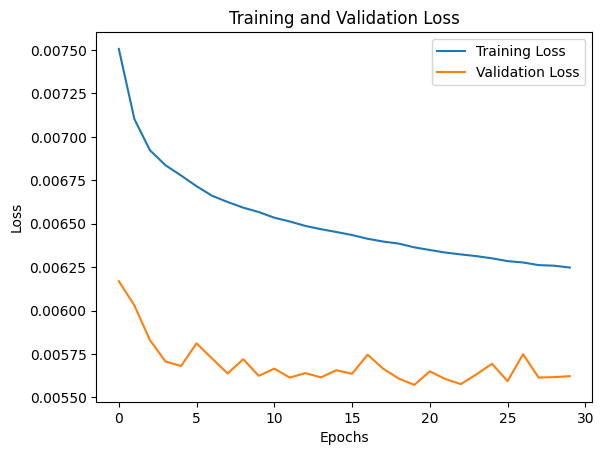

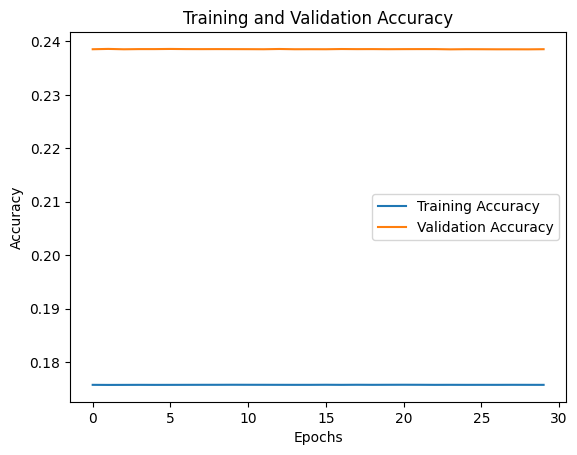

In [ ]:


# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set and evaluate the model
test_predictions = []
for X_test_meter in X_test_list:
    test_predictions.append(model.predict(X_test_meter))


74/74 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 9ms/step


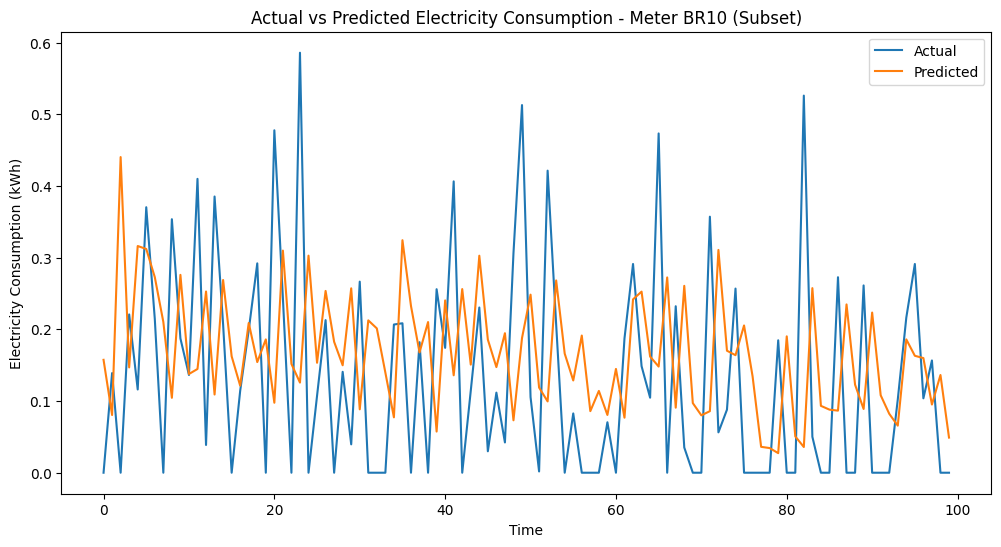

In [ ]:
# Select a meter for prediction
meter_index = 8  # Change this index to select a different meter
X_test_meter = X_test_list[meter_index]  # Get the test sequences for the selected meter
y_test_meter = y_test_list[meter_index]  # Get the actual values for the selected meter

# Select a subset of sequences for prediction (e.g., the first 100 sequences)
X_subset = X_test_meter[:100]

# Make predictions for the subset
predictions = model.predict(X_subset)

# Plot actual vs. predicted values for the subset
plt.figure(figsize=(12, 6))
plt.plot(y_test_meter[:100], label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption (kWh)')
plt.title(f'Actual vs Predicted Electricity Consumption - Meter {meters[meter_index]} (Subset)')
plt.legend()
plt.show()


In [ ]:
# Plotting without transforming the test data
plt.plot(y_test, label='Actual')
plt.plot(test_pred, label='Predicted')

plt.xlabel('Time')
plt.ylabel('Electricity Consumption (kWh)')
plt.title('Actual vs Predicted Electricity Consumption')
plt.legend()
plt.show()